# Benchmark Throughput experiment (Switch)
This notebook will show you how to measure the throughput between two Alveo nodes using the benchmark application with UDP as a transport protocol.
We are going to rely on a Dask cluster to configure the local and remote Alveo cards.

This notebook assumes:
* The Alveo cards are connected to a switch
* Dask cluster is already created and running. For more information about setting up a Dask cluster visit the [Dask documentation](https://docs.dask.org/en/latest/setup.html)

## Connect to the Dask cluster
1. Connect to the Dask cluster
1. Grab workers name
1. Check if there are two workers available

In [1]:
from dask.distributed import Client, get_client

client = Client("tcp://10.1.212.127:8786")
client

Client Scheduler: tcp://10.1.212.127:8786 Dashboard: http://10.1.212.127:8787/status,Cluster Workers: 2 Cores: 32 Memory: 232.35 GB


In [2]:
client_info = client.scheduler_info()['workers']
workers = []
for cli in client_info:
    workers.append(client_info[cli]['name'])

if len(workers) != 2:
    print("Configure your Dask cluster with two workers")

## Basic remote functions
In this part we are going to schedule a basic function to the workers to verify that we are able to pinpoint tasks to a particular worker, we are also going to grab the Alveo shell name.
You should visually check that your xclbin file is built for the Alveo shell available on the workers.

In [3]:
import platform, os

def verify_workers():
    node_name = platform.node()
    shell_version = os.popen("xbutil dump | grep dsa_name").read()
    #match = True
    #if 'xilinx_u280_xdma_201920_3' not in shell_version:
    #    match = False
    return node_name, shell_version[24:-2]

worker_0 = client.submit(verify_workers ,workers=workers[0], pure=False)
worker_1 = client.submit(verify_workers ,workers=workers[1], pure=False)

worker_check = [worker_0.result(),worker_1.result()]

for w in worker_check:
    print('Worker name: {} | shell version: {}'.format(w[0],w[1]))

Worker name: alveo3c | shell version: "xilinx_u280_xdma_201920_3"
Worker name: alveo4b | shell version: "xilinx_u280_xdma_201920_3"


## Source Dask device and utilities

In this section we will import the libraries and dask on pynq class which allow us to:

* Download a `xclbin` file to a worker
* Peek and poke registers
* Allocate buffers
* Start kernels

All of these capabilities are available for both local and remote workers

In [4]:
from vnx_utils import *
import pynq
%run dask_pynq.py

## Download xclbin to Alveo cards
1. Create Dask device for each worker
2. Create an overlay object for each worker, this step will download the `xclbin` file to the Alveo card

In [5]:
daskdev_w0 = DaskDevice(client, workers[0])
daskdev_w1 = DaskDevice(client, workers[1])

xclbin = '../benchmark.intf3.xilinx_u280_xdma_201920_3/vnx_benchmark_if3.xclbin'
ol_w0 = pynq.Overlay(xclbin, device=daskdev_w0)
ol_w1 = pynq.Overlay(xclbin, device=daskdev_w1)

/mnt/scratch/marruiz/conda/lib/python3.7/site-packages/distributed/worker.py:3321: UserWarning: Large object of size 51.33 MB detected in task graph: 
  (b'xclbin2\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff ... ROR_DATA_END',)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


## Check Link 

We are going to use the function `link_status` that reports if the CMAC is detecting link, which means that the physical connection
between each Alveo card and the switch is established.

In [6]:
print("Link worker 0 {}; link worker 1 {}".format(ol_w0.cmac_0.link_status(),ol_w1.cmac_0.link_status()))

Link worker 0 {'cmac_link': True}; link worker 1 {'cmac_link': True}


## Configure IP address of the Alveo cards
In the next cell we are going to configure the IP address of the two Alveo cards

In [7]:
ip_w0 , ip_w1 = '10.1.212.199' , '10.1.212.190'
if_status_w0 = ol_w0.networklayer_0.set_ip_address(ip_w0, debug=True)
if_status_w1 = ol_w1.networklayer_0.set_ip_address(ip_w1, debug=True)
print("Worker 0: {}\nWorker 1: {}".format(if_status_w0, if_status_w1))

Worker 0: {'HWaddr': '00:0a:35:02:9d:c7', 'inet addr': '10.1.212.199', 'gateway addr': '10.1.212.1', 'Mask': '255.255.255.0'}
Worker 1: {'HWaddr': '00:0a:35:02:9d:be', 'inet addr': '10.1.212.190', 'gateway addr': '10.1.212.1', 'Mask': '255.255.255.0'}


### Configure remote Alveo card

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [8]:
ol_w1.networklayer_0.sockets[3] = (ip_w0, 62177, 60512, True)
ol_w1.networklayer_0.populate_socket_table()

ol_w1.networklayer_0.arp_discovery()

ol_w1.networklayer_0.get_arp_table()

Position   1	MAC address 04:c5:a4:e3:fb:41	IP address 10.1.212.1
Position   4	MAC address 52:54:00:90:c2:04	IP address 10.1.212.4
Position   6	MAC address 52:54:00:90:c2:06	IP address 10.1.212.6
Position  11	MAC address 00:1e:67:34:65:b8	IP address 10.1.212.11
Position  12	MAC address 00:1e:67:34:63:b8	IP address 10.1.212.12
Position  13	MAC address 00:1e:67:34:64:00	IP address 10.1.212.13
Position  14	MAC address 00:1e:67:34:65:bc	IP address 10.1.212.14
Position  15	MAC address 00:1e:67:34:64:20	IP address 10.1.212.15
Position  16	MAC address 00:1e:67:34:64:08	IP address 10.1.212.16
Position  17	MAC address 00:1e:67:34:65:18	IP address 10.1.212.17
Position  18	MAC address 00:1e:67:34:65:28	IP address 10.1.212.18
Position  24	MAC address 90:e2:ba:04:74:e0	IP address 10.1.212.24
Position  25	MAC address 0c:42:a1:7c:c9:18	IP address 10.1.212.25
Position  33	MAC address 90:e2:ba:55:df:65	IP address 10.1.212.33
Position  41	MAC address 00:25:b5:00:00:1f	IP address 10.1.212.41
Position  42	

### Configure local Alveo card

1. Set up connection table
2. Launch ARP discovery
3. Print out ARP Table 

In [9]:
ol_w0.networklayer_0.sockets[12] = (ip_w1, 60512, 62177, True)
ol_w0.networklayer_0.populate_socket_table()

ol_w0.networklayer_0.arp_discovery()

ol_w0.networklayer_0.get_arp_table()

Position   1	MAC address 04:c5:a4:e3:fb:41	IP address 10.1.212.1
Position   4	MAC address 52:54:00:90:c2:04	IP address 10.1.212.4
Position   6	MAC address 52:54:00:90:c2:06	IP address 10.1.212.6
Position  11	MAC address 00:1e:67:34:65:b8	IP address 10.1.212.11
Position  12	MAC address 00:1e:67:34:63:b8	IP address 10.1.212.12
Position  13	MAC address 00:1e:67:34:64:00	IP address 10.1.212.13
Position  14	MAC address 00:1e:67:34:65:bc	IP address 10.1.212.14
Position  15	MAC address 00:1e:67:34:64:20	IP address 10.1.212.15
Position  16	MAC address 00:1e:67:34:64:08	IP address 10.1.212.16
Position  17	MAC address 00:1e:67:34:65:18	IP address 10.1.212.17
Position  18	MAC address 00:1e:67:34:65:28	IP address 10.1.212.18
Position  24	MAC address 90:e2:ba:04:74:e0	IP address 10.1.212.24
Position  25	MAC address 0c:42:a1:7c:c9:18	IP address 10.1.212.25
Position  33	MAC address 90:e2:ba:55:df:65	IP address 10.1.212.33
Position  41	MAC address 00:25:b5:00:00:1f	IP address 10.1.212.41
Position  42	

## Configure application
* Configure remote traffic generator 0 in `CONSUMER` mode

In [10]:
ol_w1_tg = ol_w1.traffic_generator_0_3
ol_w1_tg.register_map.debug_reset = 1
ol_w1_tg.start(TgMode.CONSUMER)

* Configure local traffic generator 0
* Run the application for different packet sizes
* Compute and store results for both local (Tx) and remote (Rx)

In [11]:
import time
# overhead is UDP (8), IP (20), Ethernet(14) and FCS (4), IFG (12), preamble (7), start frame delimiter (1)
overhead = 8 + 20 + 14 + 4 + 12 + 7 + 1
freq = int(ol_w1.clock_dict['clock0']['frequency'])
ol_w0_tg = ol_w0.traffic_generator_0_3
experiment_dict = {}
local_dict = {}
ol_w0_tg.register_map.mode = TgMode.PRODUCER
ol_w1_tg.freq = freq
ol_w0_tg.freq = freq
for pkt in [1_000_000, 1_000_000_000]:
    ol_w0_tg.reset_stats()
    ol_w1_tg.reset_stats()
    local_dict = {}
    for i in range(23):
        beats = i + 1
        ol_w0_tg.register_map.number_beats = beats
        ol_w0_tg.start(TgMode.PRODUCER, 12, pkt, beats, 0)
        while int(ol_w0_tg.register_map.out_traffic_packets) != pkt:
            time.sleep(0.8)
        # Get results from local and remote worker
        rx_tot_pkt, rx_thr, rx_time = ol_w1_tg.compute_app_throughput('rx')
        tx_tot_pkt, tx_thr, tx_time = ol_w0_tg.compute_app_throughput('tx')
        #Create dict entry for this particular experiment
        entry_dict = {'size': (beats * 64), 'rx_pkts' : rx_tot_pkt, 'tx_thr': tx_thr, 'rx_thr': rx_thr}
        local_dict[beats] = entry_dict
        # Reset probes to prepare for next computation
        ol_w0_tg.reset_stats()
        ol_w1_tg.reset_stats()
        theoretical = (beats * 64 * 100)/((beats*64) + overhead) 
        print("Sent {:14,} size: {:4}-Byte done!	Got {:14,} took {:8.4f} sec, thr: {:.3f} Gbps, theoretical: {:.3f} Gbps, difference: {:.4f} Gbps"\
              .format(pkt,beats*64, rx_tot_pkt, rx_time, rx_thr, theoretical, theoretical-rx_thr))
        time.sleep(0.5)
    experiment_dict[pkt] = local_dict

Sent      1,000,000 size:   64-Byte done!	Got      1,000,000 took   0.0104 sec, thr: 49.231 Gbps, theoretical: 49.231 Gbps, difference: -0.0005 Gbps
Sent      1,000,000 size:  128-Byte done!	Got      1,000,000 took   0.0167 sec, thr: 61.297 Gbps, theoretical: 65.979 Gbps, difference: 4.6825 Gbps
Sent      1,000,000 size:  192-Byte done!	Got      1,000,000 took   0.0206 sec, thr: 74.419 Gbps, theoretical: 74.419 Gbps, difference: -0.0008 Gbps
Sent      1,000,000 size:  256-Byte done!	Got      1,000,000 took   0.0258 sec, thr: 79.504 Gbps, theoretical: 79.503 Gbps, difference: -0.0008 Gbps
Sent      1,000,000 size:  320-Byte done!	Got      1,000,000 took   0.0309 sec, thr: 82.902 Gbps, theoretical: 82.902 Gbps, difference: -0.0009 Gbps
Sent      1,000,000 size:  384-Byte done!	Got      1,000,000 took   0.0360 sec, thr: 85.334 Gbps, theoretical: 85.333 Gbps, difference: -0.0009 Gbps
Sent      1,000,000 size:  448-Byte done!	Got      1,000,000 took   0.0411 sec, thr: 87.160 Gbps, theoretic

## Plot the results
Finally we can plot the results using matplotlib

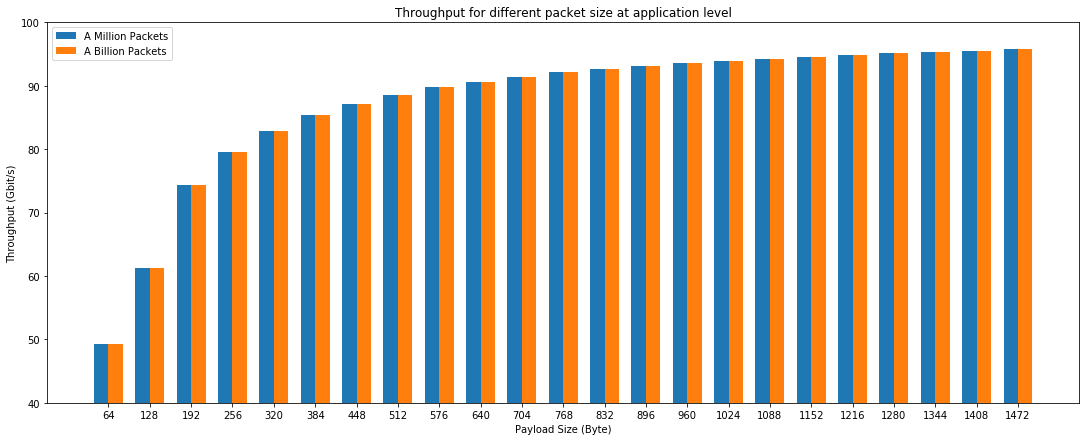

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

dict_oneM = experiment_dict[1_000_000]
dict_oneB = experiment_dict[1_000_000_000]
labels = []
oneM_thr = []
oneB_thr = []

for b in dict_oneM:
    labels.append(dict_oneM[b]['size'])
    oneM_thr.append(dict_oneM[b]['rx_thr'])

for b in dict_oneB:
    oneB_thr.append(dict_oneB[b]['rx_thr'])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, oneM_thr, width, label='A Million Packets')
rects2 = ax.bar(x + width/2, oneB_thr, width, label='A Billion Packets')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Throughput (Gbit/s)')
ax.set_xlabel('Payload Size (Byte)')
ax.set_title('Throughput for different packet size at application level')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(40,100)
fig.set_size_inches(18.5, 7)
plt.show()

## Release Alveo cards
To release the alveo cards the pynq overlay is freed

In [13]:
pynq.Overlay.free(ol_w0)
pynq.Overlay.free(ol_w1)

------------------------------------------
Copyright (c) 2020-2021, Xilinx, Inc.